<a href="https://colab.research.google.com/github/sumedh151/fusion-transformer/blob/main/dark_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio
import rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 15.2 MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tqdm
import gc
import pickle

from sklearn.metrics import confusion_matrix
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
!unzip "/content/drive/MyDrive/datasets/houston/2013_DFTC.zip"

Archive:  /content/drive/MyDrive/datasets/houston/2013_DFTC.zip
   creating: 2013_DFTC/
  inflating: 2013_DFTC/2013_IEEE_GRSS_DF_Contest_CASI.hdr  
   creating: __MACOSX/
   creating: __MACOSX/2013_DFTC/
  inflating: __MACOSX/2013_DFTC/._2013_IEEE_GRSS_DF_Contest_CASI.hdr  
  inflating: 2013_DFTC/2013_IEEE_GRSS_DF_Contest_CASI.tif  
  inflating: __MACOSX/2013_DFTC/._2013_IEEE_GRSS_DF_Contest_CASI.tif  
  inflating: 2013_DFTC/2013_IEEE_GRSS_DF_Contest_LiDAR.hdr  
  inflating: __MACOSX/2013_DFTC/._2013_IEEE_GRSS_DF_Contest_LiDAR.hdr  
  inflating: 2013_DFTC/2013_IEEE_GRSS_DF_Contest_LiDAR.tif  
  inflating: __MACOSX/2013_DFTC/._2013_IEEE_GRSS_DF_Contest_LiDAR.tif  
  inflating: 2013_DFTC/2013_IEEE_GRSS_DF_Contest_Samples_TR.roi  
  inflating: __MACOSX/2013_DFTC/._2013_IEEE_GRSS_DF_Contest_Samples_TR.roi  
  inflating: 2013_DFTC/2013_IEEE_GRSS_DF_Contest_Samples_TR.txt  
  inflating: __MACOSX/2013_DFTC/._2013_IEEE_GRSS_DF_Contest_Samples_TR.txt  
  inflating: 2013_DFTC/2013_IEEE_GRSS_DF_C

# **DATA PREPROCESSING**

In [4]:
train_co = np.genfromtxt('/content/drive/MyDrive/datasets/houston/trainingdata.txt')
test_co = np.genfromtxt('/content/drive/MyDrive/datasets/houston/test.txt')
train_co.shape, test_co.shape

((2832, 3), (12197, 3))

In [5]:
def preprocess_hs():
  ds = rasterio.open('/content/2013_DFTC/2013_IEEE_GRSS_DF_Contest_CASI.tif')
  hysp=np.zeros((144,349,1905))
  for i in range(144):
    x=ds.read(i+1)
    m=np.amax(x)
    x=x/m
    hysp[i]=x
  hysp1=np.swapaxes(hysp,2,0)

  return hysp1

In [6]:
def preprocess_ld():
  ds2=rasterio.open("/content/2013_DFTC/2013_IEEE_GRSS_DF_Contest_LiDAR.tif")
  x=ds2.read(1)
  m=np.amax(x)
  x=x/m
  ll=np.swapaxes(x,0,1)
  
  return np.expand_dims(ll, axis=-1)

In [7]:
hs = preprocess_hs()
hs.shape

(1905, 349, 144)

In [8]:
ld = preprocess_ld()
ld.shape

(1905, 349, 1)

In [9]:
def create_series_ds(image_arr,text_file_array):
  series = []
  label = []
  for i in text_file_array:
    series.append(image_arr[int(i[0]),int(i[1])])
    label.append(i[2]-1)
  series = np.asarray(series)
  label = np.asarray(label)

  return series , label

In [10]:
def create_patches_ds(patch_size, image_arr, text_file_array):
  patches = np.zeros((text_file_array.shape[0], patch_size, patch_size, image_arr.shape[2]))
  label = np.zeros((text_file_array.shape[0],))
  
  for i in range(text_file_array.shape[0]):
    x = int(text_file_array[i][0])
    y = int(text_file_array[i][1])
    label[i] = int(text_file_array[i][2]-1)

    if y>=(patch_size//2 +1) and y<=(image_arr.shape[1] - patch_size//2) and x>=(patch_size//2 +1) and x<=(image_arr.shape[0] - patch_size//2):
      patches[i] = image_arr[ x - (patch_size//2 +1) : x + (patch_size//2) , y - (patch_size//2 +1) : y + (patch_size//2) , :]
  
  return patches, label

In [11]:
patch_size=5
hs_train, hs_train_label = create_patches_ds(patch_size, hs, train_co)
hs_test, hs_test_label = create_patches_ds(patch_size, hs, test_co)

ld_train, ld_train_label = create_patches_ds(patch_size, ld, train_co)
ld_test, ld_test_label = create_patches_ds(patch_size, ld, test_co)

In [12]:
print(hs_train.shape, hs_train_label.shape)
print(hs_test.shape, hs_test_label.shape)
print(ld_train.shape, ld_train_label.shape)
print(ld_test.shape, ld_test_label.shape)

(2832, 5, 5, 144) (2832,)
(12197, 5, 5, 144) (12197,)
(2832, 5, 5, 1) (2832,)
(12197, 5, 5, 1) (12197,)


In [13]:
print((hs_train_label==ld_train_label).all())
print((hs_test_label==ld_test_label).all())

train_label=hs_train_label
test_label=hs_test_label

True
True


In [14]:
def augment(patch_size, hs_patches, ld_patches, label):
  hs_tr90 = np.empty([hs_patches.shape[0],patch_size,patch_size,144], dtype = 'float32')
  hs_tr180 = np.empty([hs_patches.shape[0],patch_size,patch_size,144], dtype = 'float32')
  hs_tr270 = np.empty([hs_patches.shape[0],patch_size,patch_size,144], dtype = 'float32')

  ld_tr90 = np.empty([ld_patches.shape[0],patch_size,patch_size,1], dtype = 'float32')
  ld_tr180 = np.empty([ld_patches.shape[0],patch_size,patch_size,1], dtype = 'float32')
  ld_tr270 = np.empty([ld_patches.shape[0],patch_size,patch_size,1], dtype = 'float32')

  for i in tqdm.tqdm(range(hs_patches.shape[0])):
    hs_tr90[i,:,:,:] = np.rot90(hs_patches[i,:,:,:])
    hs_tr180[i,:,:,:] = np.rot90(hs_tr90[i,:,:,:])
    hs_tr270[i,:,:,:] = np.rot90(hs_tr180[i,:,:,:])

    ld_tr90[i,:,:,:] = np.rot90(ld_patches[i,:,:,:])
    ld_tr180[i,:,:,:] = np.rot90(ld_tr90[i,:,:,:])
    ld_tr270[i,:,:,:] = np.rot90(ld_tr180[i,:,:,:])  

  hs_train_aug = np.concatenate([hs_patches, hs_tr90, hs_tr180, hs_tr270], axis = 0)
  ld_train_aug = np.concatenate([ld_patches, ld_tr90, ld_tr180, ld_tr270], axis = 0)
  train_label_aug = np.concatenate([train_label, train_label, train_label, train_label] , axis = 0)

  return hs_train_aug, ld_train_aug, train_label_aug

In [15]:
hs_train_aug, ld_train_aug, train_label_aug = augment(5, hs_train, ld_train, train_label)
print('\n')
print(hs_train_aug.shape)
print(ld_train_aug.shape)
print(train_label_aug.shape)

100%|██████████| 2832/2832 [00:00<00:00, 10426.60it/s]




(11328, 5, 5, 144)
(11328, 5, 5, 1)
(11328,)


In [16]:
train_label_cat = tf.keras.utils.to_categorical(train_label, num_classes=15, dtype="float32")
test_label_cat = tf.keras.utils.to_categorical(test_label, num_classes=15, dtype="float32")
train_label_aug_cat = tf.keras.utils.to_categorical(train_label_aug, num_classes=15, dtype="float32")

print(train_label_cat.shape)
print(test_label_cat.shape)
print(train_label_aug_cat.shape)


(2832, 15)
(12197, 15)
(11328, 15)


# MODEL

In [17]:
class PositionEncoder(layers.Layer):
  def __init__(self, modality_dim, projection_dim, **kwargs):
    super(PositionEncoder, self).__init__()
    self.modality_dim = modality_dim
    self.projection = layers.Dense(units=projection_dim)
    self.position_embedding = layers.Embedding(
        input_dim=modality_dim, output_dim=projection_dim
    )

  def call(self, images):
    positions = tf.range(start=0, limit=self.modality_dim, delta=1)
    encoded = self.projection(images) + self.position_embedding(positions)
    return encoded

  def get_config(self):
    config = super().get_config().copy()
    config.update({
      'modality_dim': self.modality_dim,
      'projection': self.projection,
      'position_embedding': self.position_embedding,
    })
    return config

In [18]:
class TransformerEncoder(layers.Layer):
  def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
    super(TransformerEncoder, self).__init__(**kwargs)
    self.embed_dim = embed_dim
    self.dense_dim = dense_dim      
    self.num_heads = num_heads
    self.attention = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim
    )
    self.dense_proj = keras.Sequential(
        [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
    )
    self.layernorm_1 = layers.LayerNormalization()
    self.layernorm_2 = layers.LayerNormalization()
    self.supports_masking = True

  def call(self, input, mask=None):
    if mask is not None:
        padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
    attention_output = self.attention(
        query=input, value=input, key=input
    )
    # print("attention_output",attention_output)
    proj_input = self.layernorm_1(input + attention_output)
    proj_output = self.dense_proj(proj_input)
    return self.layernorm_2(proj_input + proj_output)
  
  def get_config(self):
    config = super().get_config().copy()
    config.update({
      'embed_dim': self.embed_dim,
      'dense_dim': self.dense_dim,
      'num_heads': self.num_heads,
      'attention': self.attention,
      'dense_proj': self.dense_proj,
      'layernorm_1': self.layernorm_1,
      'layernorm_2': self.layernorm_2,
      'supports_masking': self.supports_masking,
    })
    return config

In [19]:
def dark(hs,ld, dim_f = 128):
  hs_conv1 = layers.Conv2D(dim_f,3,activation='relu',padding='same')(hs)
  ld_conv1 = layers.Conv2D(dim_f,3,activation='relu',padding='same')(ld)
  hs1 = tf.nn.sigmoid(layers.GlobalAveragePooling2D()(hs_conv1))
  ld1 = tf.nn.sigmoid(layers.GlobalAveragePooling2D()(ld_conv1))
  con = layers.Concatenate()([hs1,ld1])
  con = layers.Dense(dim_f,activation="relu")(con)
  con = layers.Dense(2*dim_f,activation="sigmoid")(con)
  ld1 = con[:,:dim_f]
  hs1 = con[:,dim_f:]
  hs_conv1 = layers.Add()([layers.Multiply()([hs_conv1,ld1]),hs_conv1])
  ld_conv1 = layers.Add()([layers.Multiply()([ld_conv1,hs1]),ld_conv1])
  
  return hs_conv1,ld_conv1

In [20]:
def mod_con(stack = 3, dim = 16, d_dim = 256 ):
  projection_dim = dim
  embed_dim = dim
  dense_dim = d_dim
  num_heads = 8

  # hyp_dim = 144
  # ld_dim = 9
  patch_size = 5

  # hs_inp = keras.Input(shape=(144,1))
  # ld_inp = keras.Input(shape=(9,1))
  hs_inp = keras.Input(shape=(patch_size,patch_size,144))
  ld_inp = keras.Input(shape=(patch_size,patch_size,1))
  hs_conv=hs_inp
  ld_conv=ld_inp

  for _ in range(2):
    hs_conv,ld_conv = dark(hs_conv,ld_conv)


  hs_avgpool = layers.GlobalAveragePooling2D()(hs_conv)
  ld_avgpool = layers.GlobalAveragePooling2D()(ld_conv)

  # hs_encoded = PositionEncoder(hyp_dim, projection_dim)(hs_inp)
  # ld_encoded = PositionEncoder(ld_dim, projection_dim)(ld_inp)
  hs_encoded = PositionEncoder(128, projection_dim)(layers.Reshape((128,1))(hs_avgpool))
  ld_encoded = PositionEncoder(128, projection_dim)(layers.Reshape((128,1))(ld_avgpool))

  encoded = layers.Concatenate(axis=1)([hs_encoded,ld_encoded])
  
  for _ in range(stack):
    encoded = TransformerEncoder(embed_dim, dense_dim, num_heads)(encoded)

  flatten = layers.Flatten()(encoded)
  # mid = layers.Dense(144, activation="relu")(flatten)
  output = layers.Dense(15, activation="softmax")(flatten)

  # model = keras.Model((hs_inp,ld_inp), (output,mid))
  return keras.Model((hs_inp,ld_inp), output)

In [21]:
m = []
# for s in [2,4,8]:
  # for d in [8,16,32]:
for s in [4,8]:
  for d in [16,32]:
    for d_dim in [128]:
      m.append(mod_con(s,d,d_dim))

In [22]:
for model in m:
  model.compile(loss= ['categorical_crossentropy'] , optimizer= tf.keras.optimizers.Adam(learning_rate=5e-6) , metrics=['accuracy'])

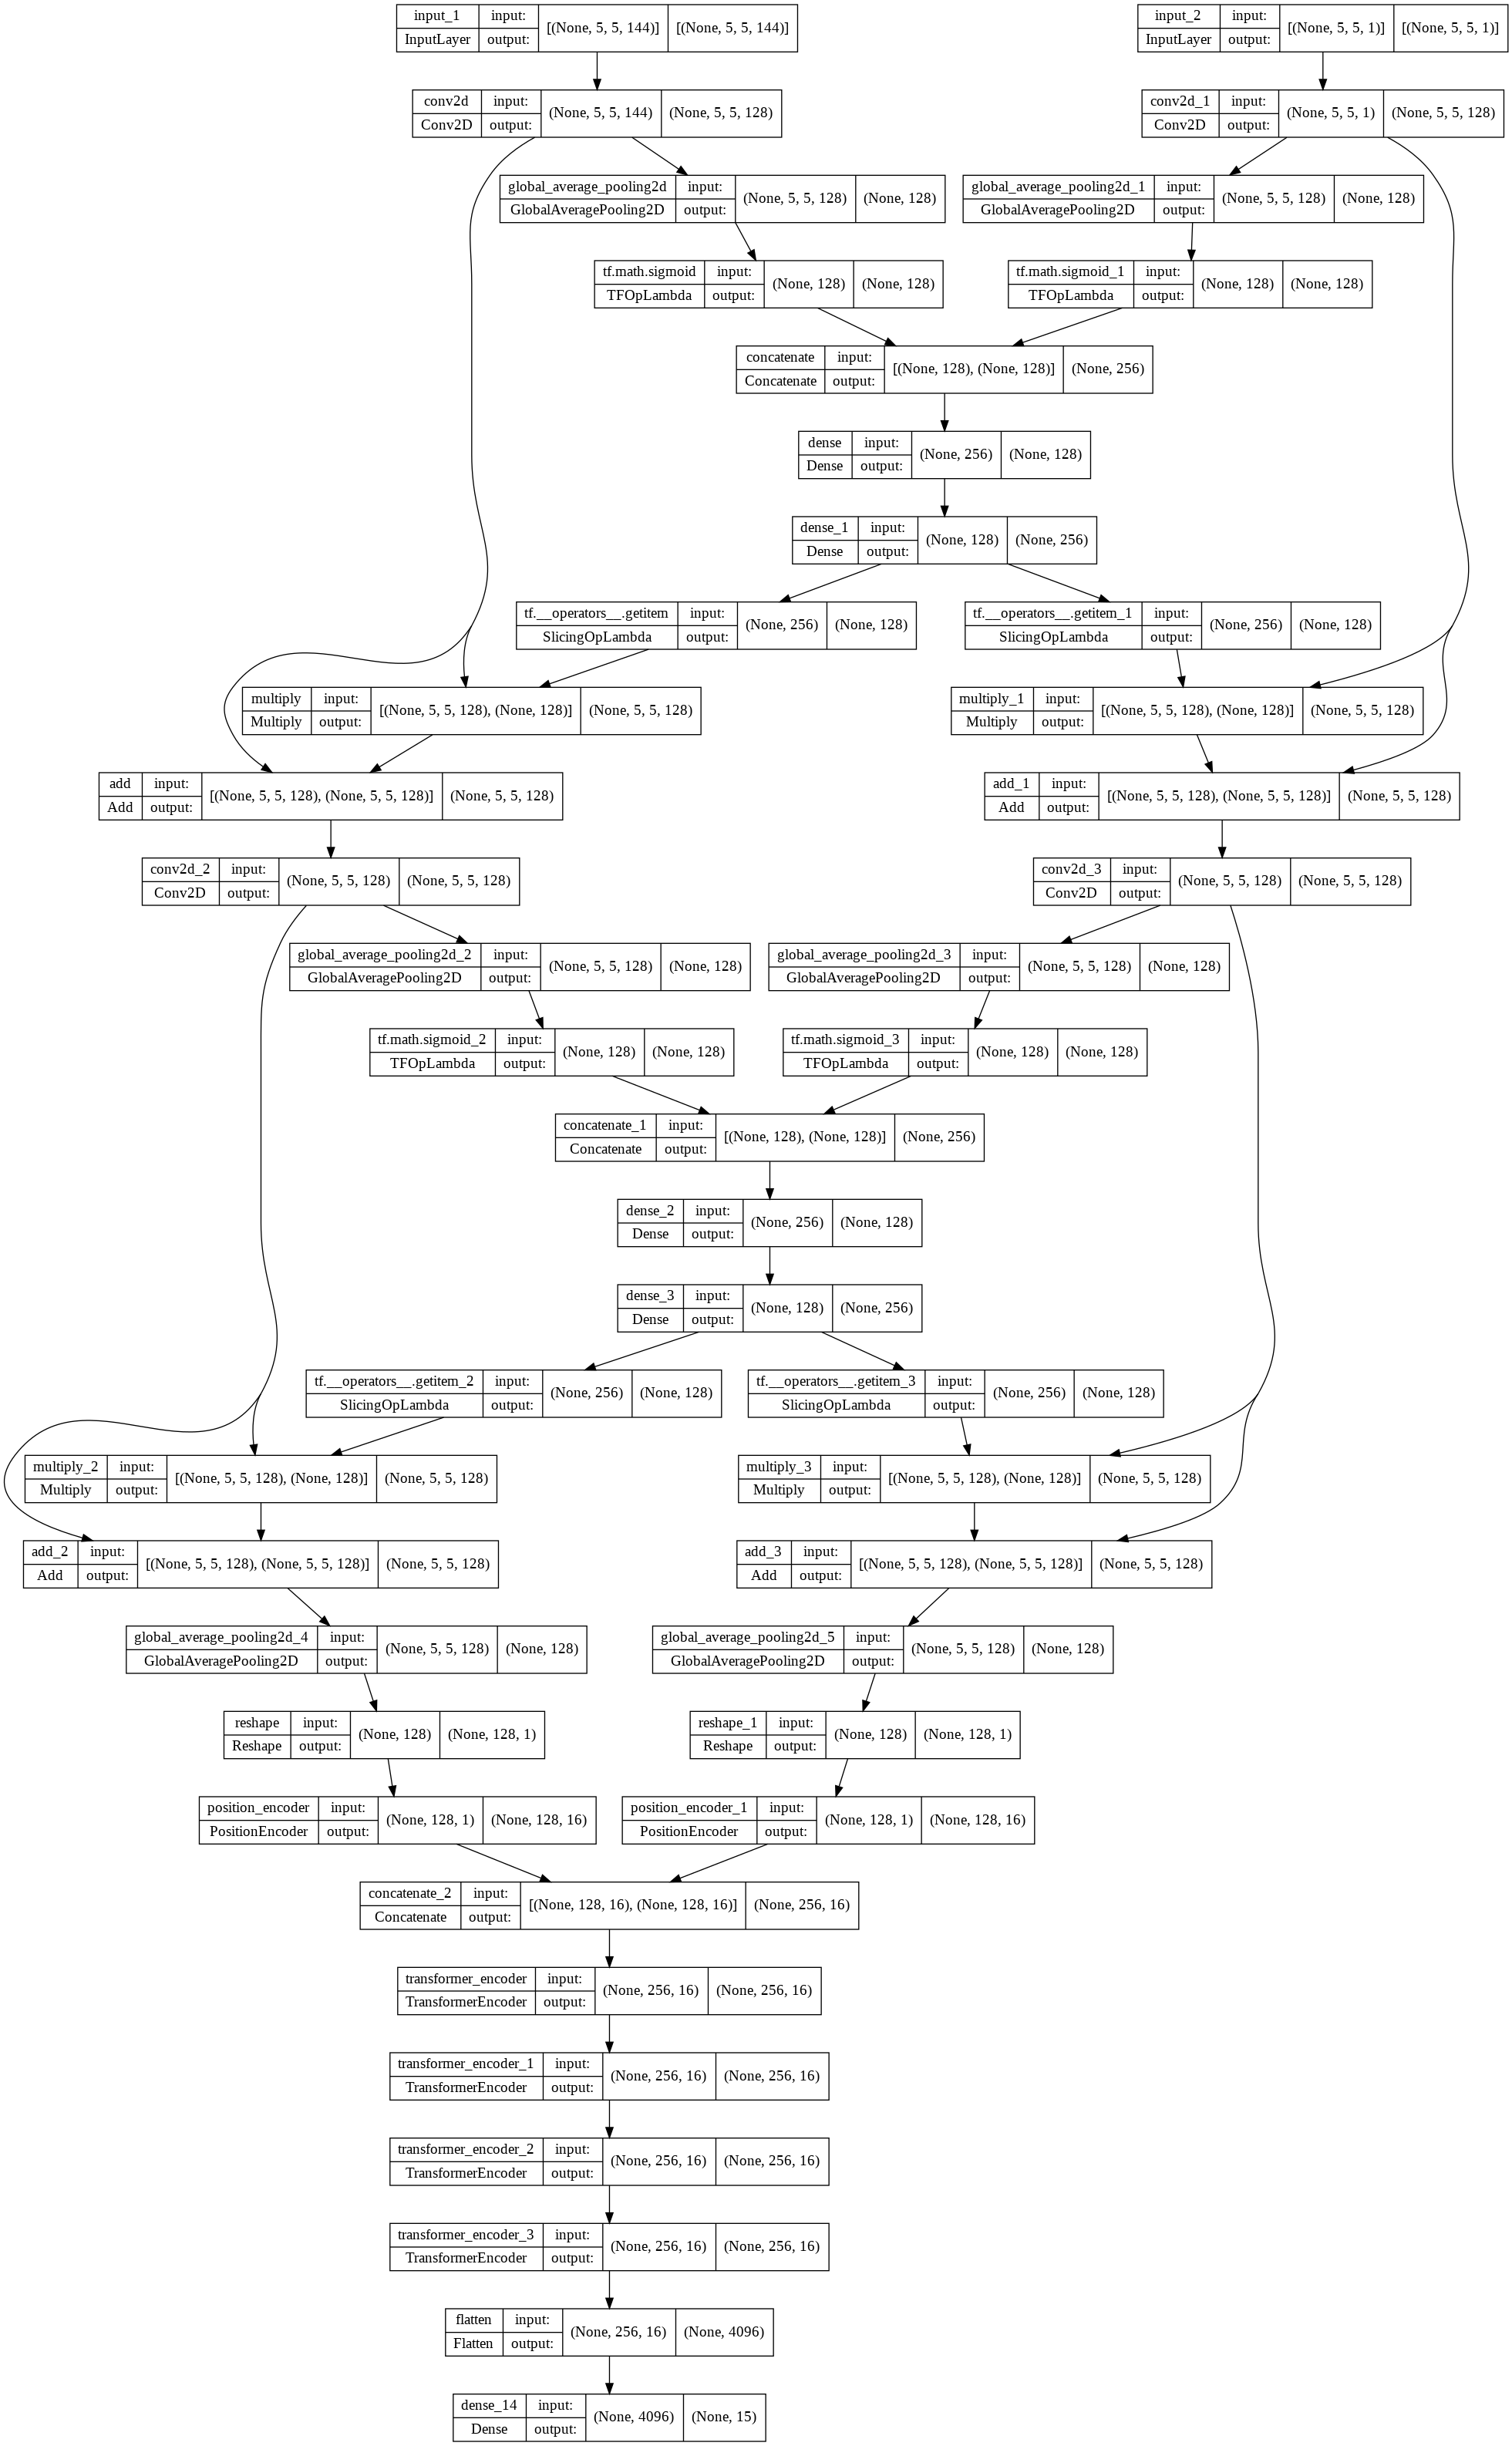

In [23]:
keras.utils.plot_model(m[0],show_shapes=True)

## **TRAINING**

In [24]:
def mask(percent,hs1,ld1):
  hs=hs1.copy()
  ld=ld1.copy()

  mask_hs = np.ones((hs.shape))
  mask_ld = np.ones((ld.shape))

  mask_hs=np.reshape(mask_hs,(-1))
  id=np.arange(len(mask_hs))
  np.random.shuffle(id)
  id=id[:int(percent*len(id))]
  # print(len(id))
  mask_hs[id]=0
  mask_hs=np.reshape(mask_hs,hs.shape)

  mask_ld=np.reshape(mask_ld,(-1))
  id=np.arange(len(mask_ld))
  np.random.shuffle(id)
  id=id[:int(percent*len(id))]
  # print(len(id))
  mask_ld[id]=0
  mask_ld=np.reshape(mask_ld,ld.shape)

  hs=hs*mask_hs
  ld=ld*mask_ld

  return hs,ld

In [25]:
highestaccuracy = [0 for _ in range(len(m))]
highestaccuracy_epoch = [0 for _ in range(len(m))]

In [47]:
# darktransformer
predsf = np.zeros((12917, 15))
epochs = 100
for i in range(epochs):
  gc.collect()
  id1 = np.arange(len(hs_train_aug))
  np.random.shuffle(id1)
  id1 = id1[:]
  hs1 = hs_train_aug[id1]
  ld1 = ld_train_aug[id1]
  h,l = mask(0.1, hs1, ld1)
  y = train_label_aug_cat[id1]
  print("epoch number:",i)
  for model in m:
    history = model.fit((h, l), y, batch_size = 32, epochs=1)
    preds = model.predict((hs_test, ld_test))
    conf = confusion_matrix(test_label, np.argmax(preds,1))
    acc = np.trace(conf)/np.sum(conf)

    if acc>highestaccuracy[m.index(model)]:
      highestaccuracy[m.index(model)] = acc
      highestaccuracy_epoch[m.index(model)] = i

    print('acc_max = ', np.round(100*highestaccuracy[m.index(model)],2), '% at epoch', highestaccuracy_epoch[m.index(model)], 'for model ', m.index(model) )
    print('epoch_acc = ', np.round(100*acc,2), '% at epoch', i ,'for model ', m.index(model) )
  print('\n')

epoch number: 0
354/354 [==============================] - 30s 45ms/step - loss: 2.4655 - accuracy: 0.3170
acc_max =  38.83 % at epoch 0 for model  0
epoch_acc =  38.83 % at epoch 0 for model  0
354/354 [==============================] - 22s 54ms/step - loss: 2.4610 - accuracy: 0.3331
acc_max =  36.66 % at epoch 0 for model  1
epoch_acc =  36.66 % at epoch 0 for model  1
354/354 [==============================] - 36s 89ms/step - loss: 2.6255 - accuracy: 0.2860
acc_max =  37.47 % at epoch 0 for model  2
epoch_acc =  37.47 % at epoch 0 for model  2
354/354 [==============================] - 41s 102ms/step - loss: 2.4541 - accuracy: 0.3076
acc_max =  43.31 % at epoch 0 for model  3
epoch_acc =  43.31 % at epoch 0 for model  3


epoch number: 1
354/354 [==============================] - 16s 46ms/step - loss: 1.7738 - accuracy: 0.6128
acc_max =  53.28 % at epoch 1 for model  0
epoch_acc =  53.28 % at epoch 1 for model  0
354/354 [==============================] - 19s 53ms/step - loss: 1.681

In [48]:
j = 0
for model in m:
  model.save("/content/drive/MyDrive/datasets/fusionmodels/dark/100/"+str(j)+".h5")
  j=j+1

In [49]:
import pickle
with open("/content/drive/MyDrive/datasets/fusionmodels/dark/100/highestaccuracy.pkl", "wb") as fp:
  pickle.dump(highestaccuracy, fp)

with open("/content/drive/MyDrive/datasets/fusionmodels/dark/100/highestaccuracy_epoch.pkl", "wb") as fp:
  pickle.dump(highestaccuracy_epoch, fp)

In [50]:
j=0
for model in m:
  results = model.evaluate((hs_test, ld_test), test_label_cat, batch_size = 32)
  print("Results for model",j)
  print("test loss, test acc:", results)
  print("\n")
  j+=1

382/382 [==============================] - 10s 23ms/step - loss: 1.4171 - accuracy: 0.7934
Results for model 0
test loss, test acc: [1.4170947074890137, 0.7933918237686157]


382/382 [==============================] - 10s 26ms/step - loss: 1.6059 - accuracy: 0.7531
Results for model 1
test loss, test acc: [1.6058835983276367, 0.7531360387802124]


382/382 [==============================] - 17s 42ms/step - loss: 1.3078 - accuracy: 0.7806
Results for model 2
test loss, test acc: [1.3077548742294312, 0.7806017994880676]


382/382 [==============================] - 20s 48ms/step - loss: 1.5485 - accuracy: 0.7781
Results for model 3
test loss, test acc: [1.548482894897461, 0.7780601978302002]




In [51]:
# darktransformer
predsf = np.zeros((12917, 15))
# epochs = 100
for i in range(100,200):
  gc.collect()
  id1 = np.arange(len(hs_train_aug))
  np.random.shuffle(id1)
  id1 = id1[:]
  hs1 = hs_train_aug[id1]
  ld1 = ld_train_aug[id1]
  h,l = mask(0.1, hs1, ld1)
  y = train_label_aug_cat[id1]
  print("epoch number:",i)
  for model in m:
    history = model.fit((h, l), y, batch_size = 32, epochs=1)
    preds = model.predict((hs_test, ld_test))
    conf = confusion_matrix(test_label, np.argmax(preds,1))
    acc = np.trace(conf)/np.sum(conf)

    if acc>highestaccuracy[m.index(model)]:
      highestaccuracy[m.index(model)] = acc
      highestaccuracy_epoch[m.index(model)] = i

    print('acc_max = ', np.round(100*highestaccuracy[m.index(model)],2), '% at epoch', highestaccuracy_epoch[m.index(model)], 'for model ', m.index(model) )
    print('epoch_acc = ', np.round(100*acc,2), '% at epoch', i ,'for model ', m.index(model) )
  print('\n')

epoch number: 100
354/354 [==============================] - 16s 46ms/step - loss: 0.0333 - accuracy: 0.9917
acc_max =  79.99 % at epoch 62 for model  0
epoch_acc =  79.1 % at epoch 100 for model  0
354/354 [==============================] - 19s 54ms/step - loss: 0.0225 - accuracy: 0.9943
acc_max =  77.45 % at epoch 39 for model  1
epoch_acc =  76.82 % at epoch 100 for model  1
354/354 [==============================] - 31s 88ms/step - loss: 0.0255 - accuracy: 0.9941
acc_max =  78.11 % at epoch 90 for model  2
epoch_acc =  76.81 % at epoch 100 for model  2
354/354 [==============================] - 36s 102ms/step - loss: 0.0228 - accuracy: 0.9934
acc_max =  79.45 % at epoch 89 for model  3
epoch_acc =  77.31 % at epoch 100 for model  3


epoch number: 101
354/354 [==============================] - 16s 46ms/step - loss: 0.0313 - accuracy: 0.9914
acc_max =  79.99 % at epoch 62 for model  0
epoch_acc =  79.51 % at epoch 101 for model  0
354/354 [==============================] - 19s 53ms/

In [52]:
j=0
for model in m:
  results = model.evaluate((hs_test, ld_test), test_label_cat, batch_size = 32)
  print("Results for model",j)
  print("test loss, test acc:", results)
  print("\n")
  j+=1

382/382 [==============================] - 9s 23ms/step - loss: 1.7277 - accuracy: 0.7984
Results for model 0
test loss, test acc: [1.7277348041534424, 0.7983930706977844]


382/382 [==============================] - 10s 26ms/step - loss: 1.8358 - accuracy: 0.7783
Results for model 1
test loss, test acc: [1.8358433246612549, 0.7783061265945435]


382/382 [==============================] - 16s 41ms/step - loss: 1.7003 - accuracy: 0.7741
Results for model 2
test loss, test acc: [1.7002922296524048, 0.774124801158905]


382/382 [==============================] - 18s 47ms/step - loss: 1.9032 - accuracy: 0.7747
Results for model 3
test loss, test acc: [1.9032496213912964, 0.7746986746788025]




In [53]:
j = 0
for model in m:
  model.save("/content/drive/MyDrive/datasets/fusionmodels/dark/200/"+str(j)+".h5")
  j=j+1

In [54]:
import pickle
with open("/content/drive/MyDrive/datasets/fusionmodels/dark/200/highestaccuracy.pkl", "wb") as fp:
  pickle.dump(highestaccuracy, fp)

with open("/content/drive/MyDrive/datasets/fusionmodels/dark/200/highestaccuracy_epoch.pkl", "wb") as fp:
  pickle.dump(highestaccuracy_epoch, fp)

In [55]:
# darktransformer
predsf = np.zeros((12917, 15))
# epochs = 100
for i in range(200,300):
  gc.collect()
  id1 = np.arange(len(hs_train_aug))
  np.random.shuffle(id1)
  id1 = id1[:]
  hs1 = hs_train_aug[id1]
  ld1 = ld_train_aug[id1]
  h,l = mask(0.1, hs1, ld1)
  y = train_label_aug_cat[id1]
  print("epoch number:",i)
  for model in m:
    history = model.fit((h, l), y, batch_size = 32, epochs=1)
    preds = model.predict((hs_test, ld_test))
    conf = confusion_matrix(test_label, np.argmax(preds,1))
    acc = np.trace(conf)/np.sum(conf)

    if acc>highestaccuracy[m.index(model)]:
      highestaccuracy[m.index(model)] = acc
      highestaccuracy_epoch[m.index(model)] = i

    print('acc_max = ', np.round(100*highestaccuracy[m.index(model)],2), '% at epoch', highestaccuracy_epoch[m.index(model)], 'for model ', m.index(model) )
    print('epoch_acc = ', np.round(100*acc,2), '% at epoch', i ,'for model ', m.index(model) )
  print('\n')

epoch number: 200
354/354 [==============================] - 17s 47ms/step - loss: 0.0129 - accuracy: 0.9967
acc_max =  80.84 % at epoch 170 for model  0
epoch_acc =  79.28 % at epoch 200 for model  0
354/354 [==============================] - 19s 53ms/step - loss: 0.0124 - accuracy: 0.9957
acc_max =  78.97 % at epoch 113 for model  1
epoch_acc =  78.91 % at epoch 200 for model  1
354/354 [==============================] - 31s 88ms/step - loss: 0.0129 - accuracy: 0.9961
acc_max =  78.86 % at epoch 166 for model  2
epoch_acc =  76.22 % at epoch 200 for model  2
354/354 [==============================] - 36s 102ms/step - loss: 0.0101 - accuracy: 0.9970
acc_max =  80.01 % at epoch 200 for model  3
epoch_acc =  80.01 % at epoch 200 for model  3


epoch number: 201
354/354 [==============================] - 16s 46ms/step - loss: 0.0120 - accuracy: 0.9967
acc_max =  80.84 % at epoch 170 for model  0
epoch_acc =  80.2 % at epoch 201 for model  0
354/354 [==============================] - 19s 

In [60]:
j=0
for model in m:
  results = model.evaluate((hs_test, ld_test), test_label_cat, batch_size = 32)
  print("Results for model",j)
  print("test loss, test acc:", results)
  print("\n")
  j+=1

382/382 [==============================] - 9s 23ms/step - loss: 2.0457 - accuracy: 0.7909
Results for model 0
test loss, test acc: [2.045722007751465, 0.7908502221107483]


382/382 [==============================] - 10s 26ms/step - loss: 2.0468 - accuracy: 0.7614
Results for model 1
test loss, test acc: [2.046755313873291, 0.7614167332649231]


382/382 [==============================] - 16s 42ms/step - loss: 1.8356 - accuracy: 0.7877
Results for model 2
test loss, test acc: [1.8355847597122192, 0.7877346873283386]


382/382 [==============================] - 18s 47ms/step - loss: 2.0178 - accuracy: 0.7905
Results for model 3
test loss, test acc: [2.0178308486938477, 0.7905222773551941]




In [59]:
j = 0
for model in m:
  model.save("/content/drive/MyDrive/datasets/fusionmodels/dark/300/"+str(j)+".h5")
  j=j+1

In [58]:
import pickle
with open("/content/drive/MyDrive/datasets/fusionmodels/dark/300/highestaccuracy.pkl", "wb") as fp:
  pickle.dump(highestaccuracy, fp)

with open("/content/drive/MyDrive/datasets/fusionmodels/dark/300/highestaccuracy_epoch.pkl", "wb") as fp:
  pickle.dump(highestaccuracy_epoch, fp)

In [61]:
# darktransformer
predsf = np.zeros((12917, 15))
# epochs = 100
for i in range(300,400):
  gc.collect()
  id1 = np.arange(len(hs_train_aug))
  np.random.shuffle(id1)
  id1 = id1[:]
  hs1 = hs_train_aug[id1]
  ld1 = ld_train_aug[id1]
  h,l = mask(0.15, hs1, ld1)
  y = train_label_aug_cat[id1]
  print("epoch number:",i)
  for model in m:
    history = model.fit((h, l), y, batch_size = 32, epochs=1)
    preds = model.predict((hs_test, ld_test))
    conf = confusion_matrix(test_label, np.argmax(preds,1))
    acc = np.trace(conf)/np.sum(conf)

    if acc>highestaccuracy[m.index(model)]:
      highestaccuracy[m.index(model)] = acc
      highestaccuracy_epoch[m.index(model)] = i

    print('acc_max = ', np.round(100*highestaccuracy[m.index(model)],2), '% at epoch', highestaccuracy_epoch[m.index(model)], 'for model ', m.index(model) )
    print('epoch_acc = ', np.round(100*acc,2), '% at epoch', i ,'for model ', m.index(model) )
  print('\n')

epoch number: 300
354/354 [==============================] - 16s 46ms/step - loss: 0.0166 - accuracy: 0.9950
acc_max =  81.13 % at epoch 260 for model  0
epoch_acc =  75.87 % at epoch 300 for model  0
354/354 [==============================] - 19s 55ms/step - loss: 0.0155 - accuracy: 0.9941
acc_max =  79.5 % at epoch 250 for model  1
epoch_acc =  72.11 % at epoch 300 for model  1
354/354 [==============================] - 31s 89ms/step - loss: 0.0147 - accuracy: 0.9952
acc_max =  79.51 % at epoch 296 for model  2
epoch_acc =  74.62 % at epoch 300 for model  2
354/354 [==============================] - 36s 103ms/step - loss: 0.0114 - accuracy: 0.9967
acc_max =  80.58 % at epoch 239 for model  3
epoch_acc =  72.95 % at epoch 300 for model  3


epoch number: 301
354/354 [==============================] - 16s 46ms/step - loss: 0.0142 - accuracy: 0.9961
acc_max =  81.13 % at epoch 260 for model  0
epoch_acc =  76.61 % at epoch 301 for model  0
354/354 [==============================] - 19s 

In [62]:
j=0
for model in m:
  results = model.evaluate((hs_test, ld_test), test_label_cat, batch_size = 32)
  print("Results for model",j)
  print("test loss, test acc:", results)
  print("\n")
  j+=1

382/382 [==============================] - 9s 22ms/step - loss: 2.1828 - accuracy: 0.7704
Results for model 0
test loss, test acc: [2.1827962398529053, 0.770353376865387]


382/382 [==============================] - 10s 25ms/step - loss: 2.2528 - accuracy: 0.7385
Results for model 1
test loss, test acc: [2.252772092819214, 0.7385422587394714]


382/382 [==============================] - 16s 41ms/step - loss: 2.1156 - accuracy: 0.7506
Results for model 2
test loss, test acc: [2.1155974864959717, 0.750594437122345]


382/382 [==============================] - 18s 47ms/step - loss: 2.2799 - accuracy: 0.7605
Results for model 3
test loss, test acc: [2.279917001724243, 0.7605148553848267]




In [63]:
j = 0
for model in m:
  model.save("/content/drive/MyDrive/datasets/fusionmodels/dark/400/"+str(j)+".h5")
  j=j+1

In [64]:
import pickle
with open("/content/drive/MyDrive/datasets/fusionmodels/dark/400/highestaccuracy.pkl", "wb") as fp:
  pickle.dump(highestaccuracy, fp)

with open("/content/drive/MyDrive/datasets/fusionmodels/dark/400/highestaccuracy_epoch.pkl", "wb") as fp:
  pickle.dump(highestaccuracy_epoch, fp)

# **OUTPUT**

In [26]:
m = []
for j in range(9):
  m.append(keras.models.load_model("/content/drive/MyDrive/datasets/fusionmodels/dark/300/"+str(j)+".h5", custom_objects={'PositionEncoder': PositionEncoder()}))

TypeError: ignored

In [ ]:
for s in [4,8]:
  for d in [16,32]:
    for d_dim in [128]:
      m.append(mod_con(s,d,d_dim))

In [25]:
model = keras.models.load_model("/content/drive/MyDrive/datasets/fusionmodels/dark/300/0.h5", custom_objects={'PositionEncoder': PositionEncoder})

TypeError: ignored

In [ ]:
m = []
# for s in [2,4,8]:
  # for d in [8,16,32]:
for s in [4,8]:
  for d in [16,32]:
    for d_dim in [128]:
      m.append(mod_con(s,d,d_dim))

In [27]:
model = mod_con(4,16,128)

In [29]:
m = []
m.append(model)

In [30]:
highestaccuracy = [0 for _ in range(len(m))]
highestaccuracy_epoch = [0 for _ in range(len(m))]

In [41]:
for model in m:
  model.compile(loss= ['categorical_crossentropy'] , optimizer= tf.keras.optimizers.Adam(learning_rate=5e-7) , metrics=['accuracy'])

In [34]:
# without mask
# darktransformer
predsf = np.zeros((12917, 15))
epochs = 200
for i in range(epochs):
  gc.collect()
  id1 = np.arange(len(hs_train_aug))
  np.random.shuffle(id1)
  id1 = id1[:]
  hs1 = hs_train_aug[id1]
  ld1 = ld_train_aug[id1]
  # h,l = mask(0.1, hs1, ld1)
  h,l = hs1, ld1
  y = train_label_aug_cat[id1]
  print("epoch number:",i)
  for model in m:
    history = model.fit((h, l), y, batch_size = 32, epochs=1)
    preds = model.predict((hs_test, ld_test))
    conf = confusion_matrix(test_label, np.argmax(preds,1))
    acc = np.trace(conf)/np.sum(conf)

    if acc>highestaccuracy[m.index(model)]:
      highestaccuracy[m.index(model)] = acc
      highestaccuracy_epoch[m.index(model)] = i

    print('acc_max = ', np.round(100*highestaccuracy[m.index(model)],2), '% at epoch', highestaccuracy_epoch[m.index(model)], 'for model ', m.index(model) )
    print('epoch_acc = ', np.round(100*acc,2), '% at epoch', i ,'for model ', m.index(model) )
  print('\n')

epoch number: 0
354/354 [==============================] - 29s 44ms/step - loss: 2.5037 - accuracy: 0.3310
acc_max =  43.45 % at epoch 0 for model  0
epoch_acc =  43.45 % at epoch 0 for model  0


epoch number: 1
354/354 [==============================] - 16s 44ms/step - loss: 1.7971 - accuracy: 0.6565
acc_max =  56.38 % at epoch 1 for model  0
epoch_acc =  56.38 % at epoch 1 for model  0


epoch number: 2
354/354 [==============================] - 16s 45ms/step - loss: 1.3691 - accuracy: 0.7307
acc_max =  62.32 % at epoch 2 for model  0
epoch_acc =  62.32 % at epoch 2 for model  0


epoch number: 3
354/354 [==============================] - 16s 45ms/step - loss: 1.0568 - accuracy: 0.7856
acc_max =  63.1 % at epoch 3 for model  0
epoch_acc =  63.1 % at epoch 3 for model  0


epoch number: 4
354/354 [==============================] - 16s 44ms/step - loss: 0.8441 - accuracy: 0.8208
acc_max =  67.77 % at epoch 4 for model  0
epoch_acc =  67.77 % at epoch 4 for model  0


epoch number: 5
3

In [42]:
# without mask
# darktransformer
predsf = np.zeros((12917, 15))
# epochs = 100
for i in range(200,300):
  gc.collect()
  id1 = np.arange(len(hs_train_aug))
  np.random.shuffle(id1)
  id1 = id1[:]
  hs1 = hs_train_aug[id1]
  ld1 = ld_train_aug[id1]
  # h,l = mask(0.1, hs1, ld1)
  h,l = hs1, ld1
  y = train_label_aug_cat[id1]
  print("epoch number:",i)
  for model in m:
    history = model.fit((h, l), y, batch_size = 32, epochs=1)
    preds = model.predict((hs_test, ld_test))
    conf = confusion_matrix(test_label, np.argmax(preds,1))
    acc = np.trace(conf)/np.sum(conf)

    if acc>highestaccuracy[m.index(model)]:
      highestaccuracy[m.index(model)] = acc
      highestaccuracy_epoch[m.index(model)] = i

    print('acc_max = ', np.round(100*highestaccuracy[m.index(model)],2), '% at epoch', highestaccuracy_epoch[m.index(model)], 'for model ', m.index(model) )
    print('epoch_acc = ', np.round(100*acc,2), '% at epoch', i ,'for model ', m.index(model) )
  print('\n')

epoch number: 200
354/354 [==============================] - 19s 45ms/step - loss: 8.3581e-04 - accuracy: 1.0000
acc_max =  84.19 % at epoch 163 for model  0
epoch_acc =  83.27 % at epoch 200 for model  0


epoch number: 201
354/354 [==============================] - 16s 45ms/step - loss: 7.9350e-04 - accuracy: 1.0000
acc_max =  84.19 % at epoch 163 for model  0
epoch_acc =  83.23 % at epoch 201 for model  0


epoch number: 202
354/354 [==============================] - 16s 45ms/step - loss: 7.6377e-04 - accuracy: 1.0000
acc_max =  84.19 % at epoch 163 for model  0
epoch_acc =  83.22 % at epoch 202 for model  0


epoch number: 203
354/354 [==============================] - 16s 44ms/step - loss: 7.1018e-04 - accuracy: 1.0000
acc_max =  84.19 % at epoch 163 for model  0
epoch_acc =  83.36 % at epoch 203 for model  0


epoch number: 204
354/354 [==============================] - 16s 45ms/step - loss: 6.9387e-04 - accuracy: 1.0000
acc_max =  84.19 % at epoch 163 for model  0
epoch_acc =  8

KeyboardInterrupt: ignored

In [43]:
j=0
for model in m:
  results = model.evaluate((hs_test, ld_test), test_label_cat, batch_size = 32)
  print("Results for model",j)
  print("test loss, test acc:", results)
  print("\n")
  j+=1

382/382 [==============================] - 9s 23ms/step - loss: 2.2583 - accuracy: 0.8351
Results for model 0
test loss, test acc: [2.2583205699920654, 0.8351234197616577]




In [39]:
j=0
for model in m:
  results = model.evaluate((hs_test, ld_test), test_label_cat, batch_size = 32)
  print("Results for model",j)
  print("test loss, test acc:", results)
  print("\n")
  j+=1

382/382 [==============================] - 9s 23ms/step - loss: 2.1227 - accuracy: 0.8233
Results for model 0
test loss, test acc: [2.122725009918213, 0.8233172297477722]


